# Example of creation of a passband file

This notebook show how to initialize a passband object from data and write it as a .pb file understood by the class. As an example, we will use the NIKA2 passbands generated in 2017 to take into account the new 2mm array and the new lens. 

In [1]:
%matplotlib inline
import numpy as np
import photometry as pt
from astropy.table import Table
from astropy.io import fits
from astropy import units as u

In [2]:
# This is the fits file containing the NIKA2 passbands
infile = '/Users/haussel/work/nika/Processing/Pipeline/Calibration/BP/Transmission_2017_Jan_NIKA2_v1.fits'

In [3]:
hdu = fits.open(infile)

In [4]:
# First check that we find the passband by extension name
hdu['CHANNEL2'].header['COMMENT']


 *** End of mandatory fields ***

Channel 2: FWHM=46 GHz from 124.7 to 170.6 GHz  Take 150 GHz as the refe
Data acquired at I. Neel, Grenoble with a Martin-Puplett Interferometer
obtained in 2015
NIKA2 initial configuration before going to the 30m telescope
reduced v1 2015/10/14
by A.Monfardini, A. F.X. Desert
Frequency in GHz
Atmospheric  transmission for pwv=2mm given as representative of Winter
NIKA2 transmission is measured with a Rayleigh-Jeans spectrum in input
which is thus consistent with Planets
Hence, colour corrections have to be computed
   with a R-J spectrum as the reference

 *** End of mandatory fields ***


 *** End of mandatory fields ***


 *** End of mandatory fields ***


 *** End of mandatory fields ***


 *** Column names ***


 *** Column names ***


 *** Column names ***


 *** Column names ***


 *** Column names ***


 *** Column formats ***


 *** Column formats ***


 *** Column formats ***


 *** Column formats ***


 *** Column formats ***

In [5]:
tpb1h = Table.read(infile, hdu='CHANNEL1H')

In [6]:
# here is what we just read
tpb1h

FREQ,NIKATRANS,ERROR,ATMTRANS
float32,float32,float32,float32
0.0,0.0,2.29932e-17,1.0
3.22814,0.0,0.0013247,0.999842
6.45629,0.0,0.00071371,0.999577
9.68443,0.0,0.00137174,0.999006
12.9126,0.0,0.000498049,0.998037
16.1407,0.0,0.00108322,0.996534
19.3689,0.0,0.00133898,0.98931
22.597,0.0,0.000665577,0.986391
25.8252,0.0,0.00067991,0.987868


In [7]:
# No need for so many zeros
idx1h, = np.where(tpb1h['NIKATRANS'] > 0)

In [8]:
x = tpb1h['FREQ'][idx1h[0]-2:idx1h[-1]+3].data * u.GHz
y = tpb1h['NIKATRANS'][idx1h[0]-2:idx1h[-1]+3].data

In [9]:
# We create a header with all the relevant information
hd = pt.PassbandHeader()

In [10]:
hd.add_card_value('instrument', 'NIKA2')
hd.add_card_value('filter', '1mmH')
hd.add_card_value('xunit', u.GHz)
hd.add_card_value('xtype', 'nu')
hd.add_card_value('xref', 260.0)
hd.add_card_value('ytype', 'rsr')


# This is the name we want to use. 
hd.add_card_value('file', '1mmH.NIKA2.pb')

In [11]:
for i in range(3, 9):
    if i == 3:
        hd.add_card_value('comment', hdu['CHANNEL1H'].header['COMMENT'][i]+'e')
    else:
        hd.add_card_value('comment', hdu['CHANNEL1H'].header['COMMENT'][i])
for i in range(11, 14):
    hd.add_card_value('comment', hdu['CHANNEL1H'].header['COMMENT'][i])
hd.add_card_value('comment', 'Updated transmission in Jan 2017, after the change of 2mm matrix')
hd.add_card_value('comment', 'and the lenses')



In [12]:
print(hd)

############### Header #################
# instrument: NIKA2
# xref: 260.0
# xtype: nu
# comment: Channel 1H: FWHM=42 GHz from 241 to 283 GHz Take 260 GHz as the reference
# comment: Data acquired at I. Neel, Grenoble with a Martin-Puplett Interferometer
# comment: obtained in 2015
# comment: NIKA2 initial configuration before going to the 30m telescope
# comment: reduced v1 2015/10/14
# comment: by A.Monfardini, A. F.X. Desert
# comment: NIKA2 transmission is measured with a Rayleigh-Jeans spectrum in input
# comment: which is thus consistent with Planets
# comment: Hence, colour corrections have to be computed
# comment: Updated transmission in Jan 2017, after the change of 2mm matrix
# comment: and the lenses
# ytype: rsr
# filter: 1mmH
# file: 1mmH.NIKA2.pb
# xunit: GHz
############### End of Header #################


In [13]:
pb1mmh = pt.Passband(x=x, y=y, header=hd)

In [14]:
print(pb1mmh)

############### Header #################
# instrument: NIKA2
# xref: 260.0
# xtype: nu
# comment: Channel 1H: FWHM=42 GHz from 241 to 283 GHz Take 260 GHz as the reference
# comment: Data acquired at I. Neel, Grenoble with a Martin-Puplett Interferometer
# comment: obtained in 2015
# comment: NIKA2 initial configuration before going to the 30m telescope
# comment: reduced v1 2015/10/14
# comment: by A.Monfardini, A. F.X. Desert
# comment: NIKA2 transmission is measured with a Rayleigh-Jeans spectrum in input
# comment: which is thus consistent with Planets
# comment: Hence, colour corrections have to be computed
# comment: Updated transmission in Jan 2017, after the change of 2mm matrix
# comment: and the lenses
# ytype: rsr
# filter: 1mmH
# file: 1mmH.NIKA2.pb
# xunit: GHz
############### End of Header #################


In [15]:
pb1mmh.header.add_card_value('bandwidth', 42*u.GHz)

In [16]:
pb1mmh.write(u.GHz, overwrite='True')

'/Users/haussel/work/python/photometry/data/passbands/NIKA2/1mmH.NIKA2.pb'

In [17]:
# Let's do the same for the oher bands
tpb1v = Table.read(infile, hdu='CHANNEL1V')
# No need for so many zeros
idx1v, = np.where(tpb1v['NIKATRANS'] > 0)
x = tpb1v['FREQ'][idx1v[0]-2:idx1v[-1]+3].data * u.GHz
y = tpb1v['NIKATRANS'][idx1v[0]-2:idx1v[-1]+3].data
hd = pt.PassbandHeader()
hd.add_card_value('instrument', 'NIKA2')
hd.add_card_value('filter', '1mmV')
hd.add_card_value('xunit', u.GHz)
hd.add_card_value('xtype', 'nu')
hd.add_card_value('xref', 150.0)
hd.add_card_value('ytype', 'rsr')
# This is the name we want to use. 
hd.add_card_value('file', '1mmV.NIKA2.pb')
for i in range(3, 9):
    if i == 3:
        hd.add_card_value('comment', hdu['CHANNEL2'].header['COMMENT'][i]+'e')
    else:
        hd.add_card_value('comment', hdu['CHANNEL2'].header['COMMENT'][i])
for i in range(11, 14):
    hd.add_card_value('comment', hdu['CHANNEL2'].header['COMMENT'][i])
hd.add_card_value('comment', 'Updated transmission in Jan 2017, after the change of 2mm matrix')
hd.add_card_value('comment', 'and the lenses')
hd.add_card_value('bandwidth', 46 * u.GHz)
pb1mmv = pt.Passband(x=x, y=y, header=hd)
pb1mmv.write(u.GHz, overwrite=True)

'/Users/haussel/work/python/photometry/data/passbands/NIKA2/1mmV.NIKA2.pb'

In [20]:
tpb2 = Table.read(infile, hdu='CHANNEL2')
# No need for so many zeros
idx2, = np.where(tpb2['NIKATRANS'] > 0)
x = tpb2['FREQ'][idx2[0]-2:idx2[-1]+3].data * u.GHz
y = tpb2['NIKATRANS'][idx2[0]-2:idx2[-1]+3].data
hd = pt.PassbandHeader()
hd.add_card_value('instrument', 'NIKA2')
hd.add_card_value('filter', '2mm')
hd.add_card_value('xunit', u.GHz)
hd.add_card_value('xtype', 'nu')
hd.add_card_value('xref', 260.0)
hd.add_card_value('ytype', 'rsr')
# This is the name we want to use. 
hd.add_card_value('file', '2mm.NIKA2.pb')
for i in range(3, 9):
    if i == 3:
        hd.add_card_value('comment', hdu['CHANNEL2'].header['COMMENT'][i]+'e')
    else:
        hd.add_card_value('comment', hdu['CHANNEL2'].header['COMMENT'][i])
for i in range(11, 14):
    hd.add_card_value('comment', hdu['CHANNEL1V'].header['COMMENT'][i])
hd.add_card_value('comment', 'Updated transmission in Jan 2017, after the change of 2mm matrix')
hd.add_card_value('comment', 'and the lenses')
hd.add_card_value('bandwidth', 42 * u.GHz)
pb2mm = pt.Passband(x=x, y=y, header=hd)
pb2mm.write(u.GHz,overwrite=True)

'/Users/haussel/work/python/photometry/data/passbands/NIKA2/2mm.NIKA2.pb'

That's it ! The file can now be used like a normal passband

In [2]:
pb = pt.Passband(file='2mm.NIKA2.pb')

In [3]:
print(pb)

############### Header #################
# file: 2mm.NIKA2.pb
# comment: Channel 2: FWHM=46 GHz from 124.7 to 170.6 GHz  Take 150 GHz as the refee
# xunit: GHz
# xref: 260.0
# ytype: rsr
# filter: 2mm
# instrument: NIKA2
# bandwidth: 42.0 GHz
# xtype: nu
# comment: Data acquired at I. Neel, Grenoble with a Martin-Puplett Interferometer
# comment: obtained in 2015
# comment: NIKA2 initial configuration before going to the 30m telescope
# comment: reduced v1 2015/10/14
# comment: by A.Monfardini, A. F.X. Desert
# comment: NIKA2 transmission is measured with a Rayleigh-Jeans spectrum in input
# comment: which is thus consistent with Planets
# comment: Hence, colour corrections have to be computed
# comment: Updated transmission in Jan 2017, after the change of 2mm matrix
# comment: and the lenses
############### End of Header #################


let's compare it to the old one

In [4]:
pbold = pt.Passband(file='2mm.NIKA2-2015.pb')

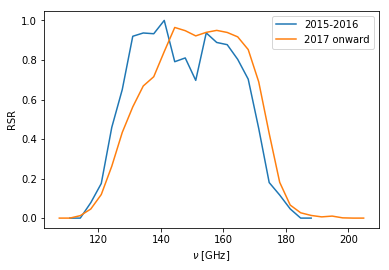

In [14]:
from matplotlib import pyplot as plt
plt.plot(pbold.nu(u.GHz), pbold.y, label='2015-2016')
plt.plot(pb.nu(u.GHz), pb.y, label='2017 onward')
plt.legend(loc='upper right')
plt.xlabel(r'$\nu$ [GHz]')
if pb.is_rsr:
    plt.ylabel('RSR')
else:
    plt.ylable('QE')


